<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Proyecto-03---Sistemas-de-Recomendación" data-toc-modified-id="Proyecto-03---Sistemas-de-Recomendación-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Proyecto 03 - Sistemas de Recomendación</a></span><ul class="toc-item"><li><span><a href="#Dataset:-STEAM" data-toc-modified-id="Dataset:-STEAM-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset: STEAM</a></span><ul class="toc-item"><li><span><a href="#Exploración-de-datos" data-toc-modified-id="Exploración-de-datos-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Exploración de datos</a></span></li><li><span><a href="#Filtro-Colaborativo" data-toc-modified-id="Filtro-Colaborativo-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Filtro Colaborativo</a></span></li><li><span><a href="#Para-pensar,-investigar-y,-opcionalmente,-implementar" data-toc-modified-id="Para-pensar,-investigar-y,-opcionalmente,-implementar-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Para pensar, investigar y, opcionalmente, implementar</a></span></li><li><span><a href="#¡Tómate-tiempo-para-investigar-y-leer-mucho!" data-toc-modified-id="¡Tómate-tiempo-para-investigar-y-leer-mucho!-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span><strong>¡Tómate tiempo para investigar y leer mucho!</strong></a></span></li></ul></li></ul></li></ul></div>

# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares? ¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [81]:
import gc
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

def parse(path):
    g = gzip.open(path, "r")
    for l in g:
        yield eval(l)

**Reviews**

In [137]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n=3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse(".\steam_reviews.json.gz"):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

Cargamos el dataset y elegimos algunas columnas a utilizar.

In [143]:
#data_reviews = pd.DataFrame(data_reviews, columns=["username", "product_id", "early_access",
#                                                   "hours", "date"])
data_reviews = pd.DataFrame(data_reviews)
reviews = data_reviews.copy()
reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [145]:
reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [ ]:
reviews.drop(columns=["products", "page_order", "page", "user_id", "compensation", "found_funny"])

Buscamos duplicados

In [144]:
mask = reviews.duplicated()
print("DUPLICADOS")
reviews[mask]

DUPLICADOS


,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny


In [71]:
name = "Spicy Michael"
data_reviews.query("username ==  @name")

,username,product_id,early_access,hours,date
2042,Spicy Michael,214560,False,9.8,2017-06-29
2046,Spicy Michael,214560,False,9.8,2017-06-29
526447,Spicy Michael,230410,False,142.9,2016-12-08


Eliminamos los duplicados y vemos cantidad de usuarios y de juegos a analizados.

In [97]:
data_reviews.drop_duplicates(inplace=True)
print("Total de juegos:", data_reviews.product_id.value_counts().count())
print("Total de usuarios:", data_reviews.username.value_counts().count())

Total de juegos: 12665
Total de usuarios: 540341


username           0
product_id         0
early_access       0
hours           2634
date               0
dtype: int64

Graficamos proporción de juegos con acceso anticipado.

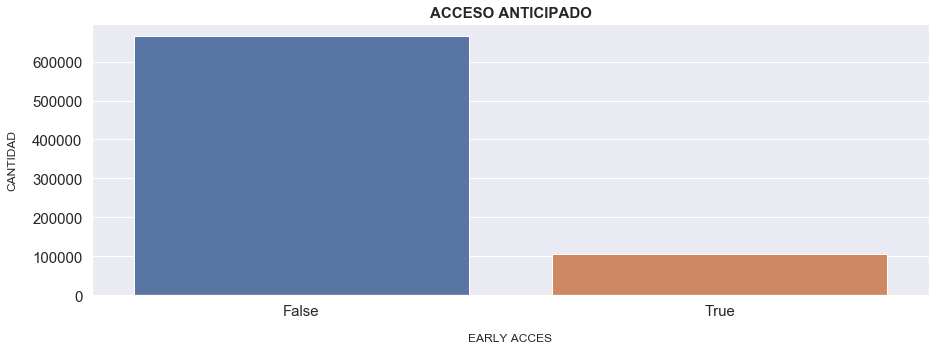

In [105]:
plt.figure(figsize=(15,5))
sns.countplot(data_reviews["early_access"])
plt.title("ACCESO ANTICIPADO", fontsize=15, fontweight="bold")
plt.tick_params(labelsize=15)
plt.xlabel("Early acces".upper(), labelpad=15)
plt.ylabel("Cantidad".upper(), labelpad=15)
plt.show()

Establecemos algunas consultas para entender un poco más el dataset. agrupamos usuarios y calculamos las horas destinadas a jugar.

In [136]:
# cantidad de usuarios sin horas cargadas
data_reviews.query("hours.isnull()", engine="python")["username"].value_counts()
data_reviews.query("hours == 0", engine="python")

,username,product_id,early_access,hours,date,dias,days
554,Bumsplikity,8880,False,0.0,2011-12-27,0.0,0.0
1887,Shooty McGungun,26900,False,0.0,2011-08-18,0.0,0.0
3685,xWhackoJacko,385770,False,0.0,2015-10-28,0.0,0.0
4258,Vince ahihi,310370,True,0.0,2015-08-22,0.0,0.0
4768,Nantuko,19980,False,0.0,2010-12-30,0.0,0.0
...,...,...,...,...,...,...,...
749145,L a u r a,361700,False,0.0,2016-03-04,0.0,0.0
749321,StrudelmonsterXL,361700,False,0.0,2015-05-07,0.0,0.0
751690,Kegel,202970,False,0.0,2013-08-12,0.0,0.0
751963,decadence.,202970,False,0.0,2013-04-18,0.0,0.0


In [100]:
data_reviews.groupby("username").agg(total_juegos=pd.NamedAgg(column="product_id", aggfunc="count"),
                                     total_horas=pd.NamedAgg(column="hours", aggfunc="sum"),
                                     total_dias=pd.NamedAgg(column="date", aggfunc="count"))

,total_juegos,total_horas,total_dias
username,,,
!,1,6.5,1
! ZerZ,2,17.9,2
! ! ŦŕĩŽǿЯëќ™ ! !,1,85.7,1
! Alga,2,52.1,2
! DeadlyDeal !,1,20.1,1
...,...,...,...
󰀓Heavy Unit󰀓,1,1089.7,1
󰀓Oxymoronicphalanx󰀓,2,2.3,2
󰀕 Africa's Population 󰀕,2,34.0,2


Vemos algunas inconsistencias, la cantidad de horas jugadas son mayores a la cantidad de días.

In [62]:
name = "󰀓Heavy Unit󰀓"
data_reviews.query("username == @name")

,username,hours,product_id,page_order,date,early_access,page
744329,󰀓Heavy Unit󰀓,1089.7,362930,3,2017-06-26,False,69


In [124]:
data_reviews["days"] = data_reviews["hours"].apply(lambda x: x/24 if x > 24 else 0).round(1)
data_reviews.head()

,username,product_id,early_access,hours,date,dias,days
0,Chaos Syren,725280,False,0.1,2017-12-17,0.0,0.0
1,Ariman1,328100,False,13.2,2017-08-02,0.0,0.0
2,freakfantom,725280,False,0.1,2017-11-12,0.0,0.0
3,The_Cpt_FROGGY,631920,False,7.8,2017-12-11,0.0,0.0
4,the_maker988,35140,False,8.2,2018-01-02,0.0,0.0


In [125]:
data_reviews.groupby("username").agg(total_juegos=pd.NamedAgg(column="product_id", aggfunc="count"),
                                     total_horas=pd.NamedAgg(column="hours", aggfunc="sum"),
                                     total_dias=pd.NamedAgg(column="days", aggfunc="sum"))

,total_juegos,total_horas,total_dias
username,,,
!,1,6.5,0.0
! ZerZ,2,17.9,0.0
! ! ŦŕĩŽǿЯëќ™ ! !,1,85.7,3.6
! Alga,2,52.1,1.3
! DeadlyDeal !,1,20.1,0.0
...,...,...,...
󰀓Heavy Unit󰀓,1,1089.7,45.4
󰀓Oxymoronicphalanx󰀓,2,2.3,0.0
󰀕 Africa's Population 󰀕,2,34.0,1.2


In [129]:
data_reviews.groupby("product_id").agg(total_usuarios=pd.NamedAgg(column="username", aggfunc="count"),
                                       total_horas=pd.NamedAgg(column="hours", aggfunc="sum"),
                                       total_dias=pd.NamedAgg(column="days", aggfunc="sum"))\
                                       .sort_values("total_horas", ascending=False).tail(50)

,total_usuarios,total_horas,total_dias
product_id,,,
220824,1,0.0,0.0
604090,1,0.0,0.0
598390,2,0.0,0.0
229660,3,0.0,0.0
541800,1,0.0,0.0
401990,1,0.0,0.0
234180,1,0.0,0.0
540070,7,0.0,0.0
342430,1,0.0,0.0


**Games**

In [21]:
data_games = []
for games in parse(".\Proyectos\Proyecto III\steam_games.json.gz"):
    data_games.append(games)
#data_games = pd.DataFrame(data_games, columns=[ "id", "app_name", "tags", "specs", "early_access", "sentiment", "metascore", "price" ])
data_games = pd.DataFrame(data_games)

In [22]:
print("Total registros:", len(data_games))
data_games.head()

Total registros: 32135


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [17]:
data_games.isna().sum()
#data_games[data_games.id == '35140']

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64